# Diffusion Process on MNIST Dataset
In this notebook, we will explore the diffusion process using the MNIST dataset. We will start by defining the variance schedule and implementing the forward process.

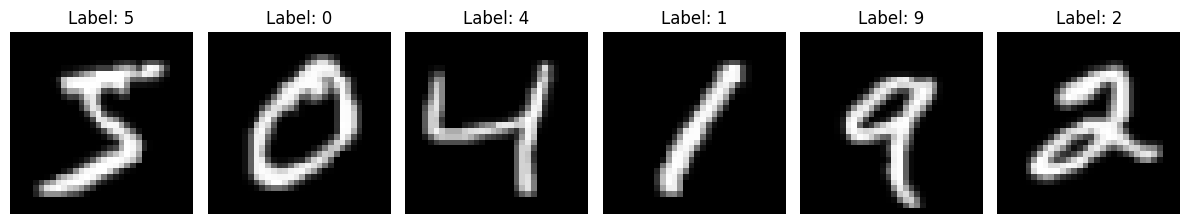

Training dataset size: 60000
Test dataset size: 10000
Image size: torch.Size([1, 32, 32])
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [6]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define the transformation for the dataset - resize to 32x32
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize MNIST from 28x28 to 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Visualize some images from the training dataset
def plot_mnist_samples(dataset, num_samples=6):
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))
    for i in range(num_samples):
        image, label = dataset[i]
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Plot some samples
plot_mnist_samples(train_dataset)

# Print dataset structure
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Image size: {train_dataset[0][0].shape}")
print(f"Classes: {train_dataset.classes}")

## Variance Schedule: Linear Schedule
The variance schedule controls the amount of noise added at each step of the forward process. For a linear schedule, the variance $\beta_t$ at timestep $t$ is defined as:

$$\beta_t = \beta_1 + t \cdot \frac{\beta_T - \beta_1}{T - 1}$$

where $\beta_1$ and $\beta_T$ are the minimum and maximum noise levels, and $T$ is the total number of timesteps.

Variance schedule: tensor([1.0000e-04, 1.1992e-04, 1.3984e-04, 1.5976e-04, 1.7968e-04, 1.9960e-04,
        2.1952e-04, 2.3944e-04, 2.5936e-04, 2.7928e-04])


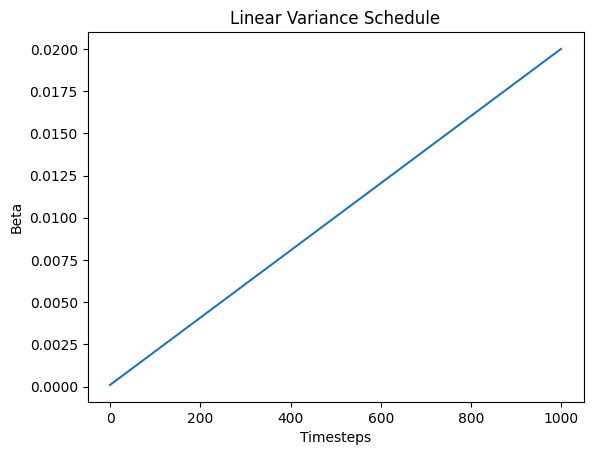

In [2]:
# Define the variance schedule
def linear_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    """Define the variance schedule"""
    return torch.linspace(beta_start, beta_end, timesteps)

# Example usage
timesteps = 1000
beta_schedule = linear_beta_schedule(timesteps)
print(f"Variance schedule: {beta_schedule[:10]}")

# Plot the variance schedule
plt.plot(beta_schedule.numpy())
plt.title("Linear Variance Schedule")
plt.xlabel("Timesteps")
plt.ylabel("Beta")
plt.show()

## Forward Process
The forward process gradually adds noise to the data. At each timestep $t$, the noisy data $\mathbf{x}_t$ is generated using the formula:

$$\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\epsilon}$$

where $\boldsymbol{\epsilon} \sim \mathcal{N}(0, \mathbf{I})$ is Gaussian noise, and $\bar{\alpha}_t$ is the cumulative product of $1 - \beta_t$.

The noise term z is set to 0 for the last generation step (when t=1). This is a specific design choice from the original DDPM paper.

Here's why:

- 1. Final Denoising Step: The reverse process iteratively denoises a sample, starting from pure noise $\mathbf{x}_T$ and aiming to produce a clean sample $\mathbf{x}_0$. The step from $\mathbf{x}_1$ to $\mathbf{x}_0$ is the final denoising step.

- 2. Mean of the Predicted Distribution: The sampling equation is: $\mathbf{x}_{t-1} = \mu\theta(\mathbf{x}_t, t) + \sigma_t \mathbf{z}$ where $\mu\theta(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}\theta(\mathbf{x}_t, t) \right)$ is the predicted mean of the distribution $p\theta(\mathbf{x}{t-1} | \mathbf{x}_t)$. When $t=1$, we are calculating $\mathbf{x}_0$. If $\mathbf{z}=0$, then $\mathbf{x}0 = \mu\theta(\mathbf{x}_1, 1)$. This means the final output $\mathbf{x}_0$ is taken to be the mean of the distribution $p\theta(\mathbf{x}_0 | \mathbf{x}_1)$ predicted by the model.

- 3. Purpose of Noise: The noise term $\sigma_t \mathbf{z}$ is added at each step $t > 1$ to introduce stochasticity, allowing the model to generate diverse samples by exploring different paths in the data manifold.

- 4. Deterministic Final Output: For the very last step ($t=1$), setting $\mathbf{z}=0$ makes the generation of $\mathbf{x}_0$ from $\mathbf{x}1$ deterministic (given the model's prediction $\boldsymbol{\epsilon}\theta(\mathbf{x}_1, 1)$). This is often preferred because the model has learned to predict the "cleanest" version of $\mathbf{x}_0$ given $\mathbf{x}1$ as $\mu\theta(\mathbf{x}_1, 1)$. Adding more noise at this final stage might slightly degrade the visual quality or sharpness of the generated sample if the goal is to obtain the model's best estimate.
In essence, the stochasticity required for generating diverse samples is primarily handled by the noise injected in steps $t=T$ down to $t=2$. The final step focuses on producing the most likely clean sample based on the learned denoising function.

In [1]:
from tqdm import tqdm

class DiffusionProcess:
    def __init__(self, beta_schedule):
        """
        Initialize the DiffusionProcess class.
        Args:
            beta_schedule (torch.Tensor): The variance schedule (beta values) for the diffusion process.
        """
        self.beta_schedule = beta_schedule
        self.alpha = 1 - beta_schedule
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.timesteps = len(beta_schedule)
        self.device = beta_schedule.device

    def corrupt_image(self, batch, t):
        """
        Get the corrupted image at timestep t.
        Args:
            batch (torch.Tensor): A batch of images (e.g., MNIST images).
            t (torch.Tensor): Timesteps for each image in the batch.
        Returns:
            torch.Tensor: The corrupted images at timestep t.
        """
        # Ensure batch and t are on the same device as beta_schedule
        batch = batch.to(self.device)
        t = t.to(self.device)
        
        # Properly reshape alpha_bar for broadcasting
        sqrt_alpha_bar_t = torch.sqrt(self.alpha_bar[t]).view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - self.alpha_bar[t]).view(-1, 1, 1, 1)

        noise = torch.randn_like(batch)  # Generate Gaussian noise
        corrupted_batch = sqrt_alpha_bar_t * batch + sqrt_one_minus_alpha_bar_t * noise
        return corrupted_batch, noise  # Return both corrupted image and noise for training

    def sample(self, model, n_samples, device, size=(1, 32, 32)):
        """
        Sample new images using the trained model.
        Args:
            model: The trained noise prediction model
            n_samples: Number of images to generate
            device: Device to run the sampling on
            size: Size of each image (channels, height, width)
        Returns:
            Generated images
        """
        model.eval()
        with torch.no_grad():
            # Start from pure noise
            x = torch.randn((n_samples, *size)).to(device)

            for t in tqdm(reversed(range(self.timesteps)), desc="Sampling"):
                # Create a batch of timesteps
                timesteps = torch.full((n_samples,), t, device=device, dtype=torch.long)

                # Predict the noise
                predicted_noise = model(x, timesteps)

                # Calculate parameters for reverse process
                alpha_t = self.alpha[t]
                alpha_bar_t = self.alpha_bar[t]
                beta_t = self.beta_schedule[t]

                # No noise at timestep 0
                if t > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = 0

                # Compute the mean for reverse process
                x = (1 / torch.sqrt(alpha_t)) * (
                    x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * predicted_noise
                ) + torch.sqrt(beta_t) * noise

        model.train()
        return x

## Visualizing the Forward Diffusion Process

Let's visualize how images get progressively noisier during the forward diffusion process. We'll take some sample images from our dataset and show what they look like at different timesteps $t$.

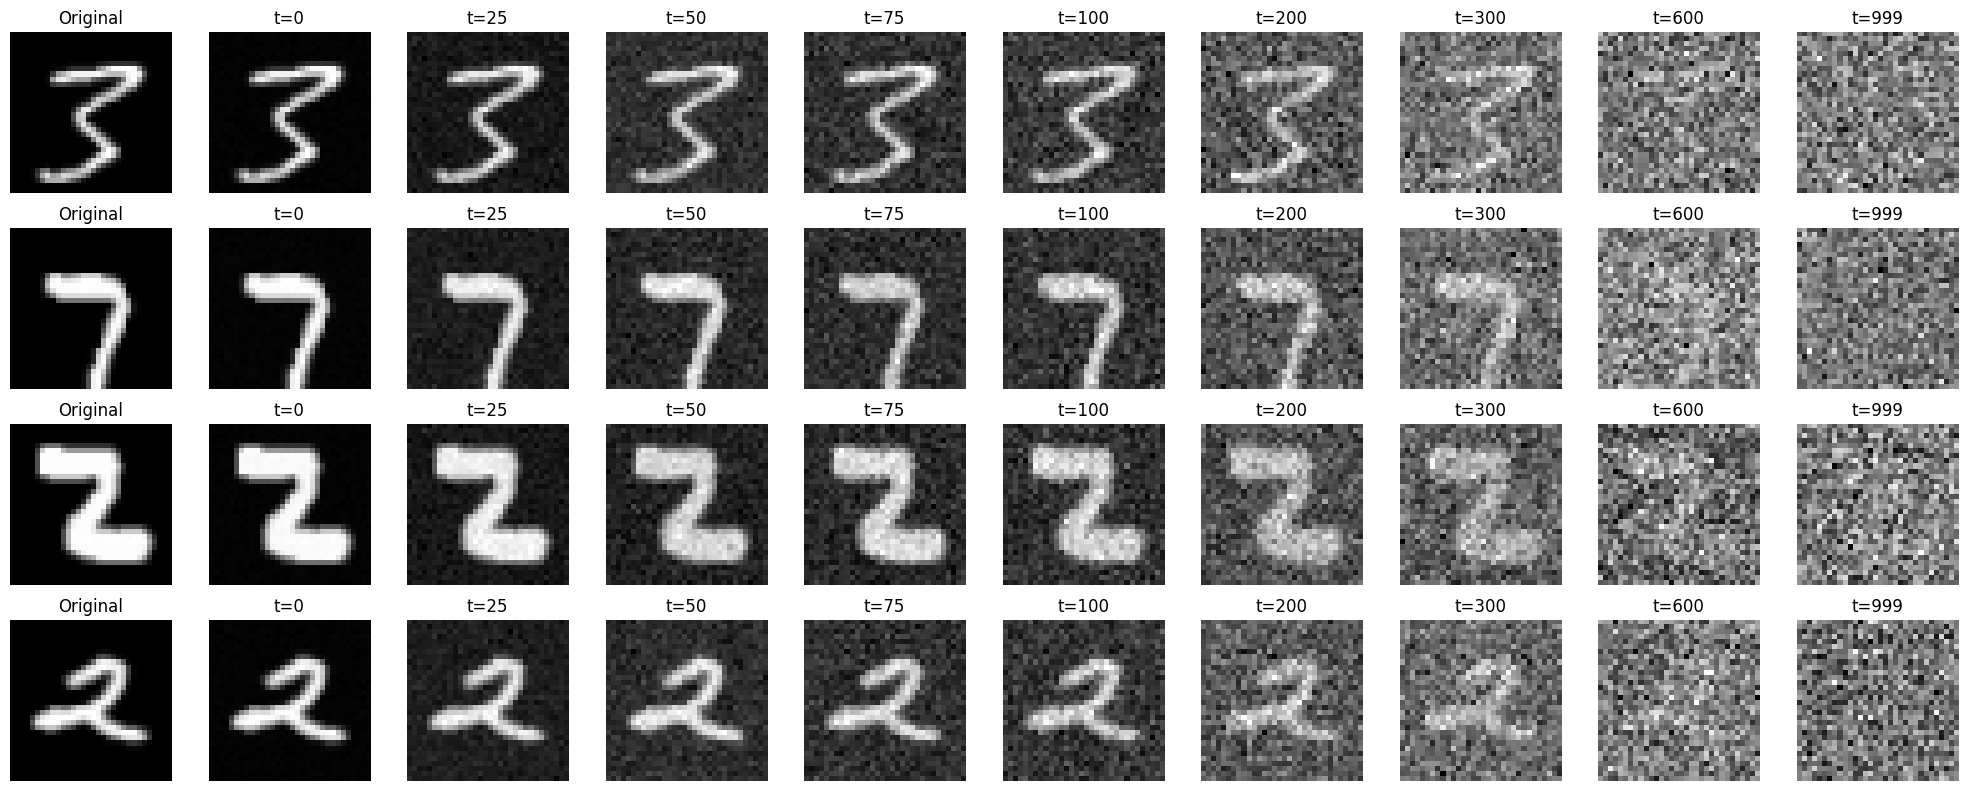

The visualization shows how images gradually become more noisy as we progress through the timesteps.
At t=0, we have the original images, and by the final timestep, the images are almost pure noise.


In [4]:
def visualize_forward_diffusion(diffusion, images, device, num_timesteps=5, steps=[0, 50, 100, 500, 999]):
    """
    Visualize the forward diffusion process on a batch of images.
    Args:
        diffusion: DiffusionProcess instance
        images: Tensor of images to visualize
        device: Device to run the diffusion on
        num_timesteps: Number of timesteps to show
    """
    if steps is None:
        timesteps = torch.linspace(0, diffusion.timesteps-1, num_timesteps).long()
    else:
        timesteps = torch.tensor(steps).long()
        num_timesteps = len(steps)

    fig, axes = plt.subplots(len(images), num_timesteps + 1, figsize=(2*(num_timesteps + 1), 2*len(images)))    
    
    for i, image in enumerate(images):
        # Show original image
        axes[i, 0].imshow(image.squeeze().cpu(), cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

        # Show noisy versions
        for j, t in enumerate(timesteps, 1):
            # Move everything to the same device
            img = image.unsqueeze(0).to(device)
            t_tensor = torch.tensor([t], device=device)
            noisy_image, _ = diffusion.corrupt_image(img, t_tensor)
            axes[i, j].imshow(noisy_image.squeeze().cpu(), cmap='gray')
            axes[i, j].set_title(f't={t.item()}')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Get some sample images
num_samples = 4
sample_indices = torch.randint(0, len(train_dataset), (num_samples,))
sample_images = torch.stack([train_dataset[i][0] for i in sample_indices])


diffusion = DiffusionProcess(beta_schedule=linear_beta_schedule(1000, beta_end=0.008))

# Visualize the forward process
visualize_forward_diffusion(diffusion, sample_images, steps=[0, 25, 50, 75, 100, 200, 300, 600, 999], device='cpu')

print("The visualization shows how images gradually become more noisy as we progress through the timesteps.")
print("At t=0, we have the original images, and by the final timestep, the images are almost pure noise.")

## Noise Prediction and Time Conditioning in Diffusion Models

As we learned from the theory, our model needs to predict the noise that was added to the image at each timestep. The key equation that defines this process is:

$$\epsilon_\theta(x_t, t) \approx \epsilon$$

where $x_t$ is the noisy image at timestep $t$, and $\epsilon$ is the original noise that was added. Remember that $x_t$ is generated using:

$$x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\epsilon$$

### Time Conditioning Methods

There are several ways to condition the UNet on time:

1. **Direct embedding**: Adding time as a channel to the input
2. **Positional embeddings**: Using sinusoidal embeddings like in transformers
3. **AdaGN (Adaptive Group Normalization)**: Modulating features based on time

$$\text{AdaGN}(h, t) = w_t \cdot \text{GroupNorm}(h) + b_t$$

where $w_t$ and $b_t$ are learned scale and bias parameters that depend on the timestep $t$. This allows the model to adapt its behavior based on the noise level at each timestep.

In [5]:
import torch.nn as nn
import math

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class AdaGN(nn.Module):
    def __init__(self, feats_in, c_hidden):
        super().__init__()
        self.norm = nn.GroupNorm(8, feats_in)
        self.proj = nn.Linear(c_hidden, 2 * feats_in)
        self.proj.weight.data.zero_()
        self.proj.bias.data.zero_()

    def forward(self, x, t):
        params = self.proj(t)  # [B, 2*feats_in]
        scale, shift = params.chunk(2, dim=1)  # Each is [B, feats_in]
        # Reshape for broadcasting
        scale = scale.view(-1, scale.shape[1], 1, 1)  # [B, C, 1, 1]
        shift = shift.view(-1, shift.shape[1], 1, 1)  # [B, C, 1, 1]
        x = self.norm(x)
        return x * (scale + 1) + shift

In [6]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.ada_gn = AdaGN(out_ch, time_emb_dim)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.relu = nn.ReLU()
        if in_ch != out_ch:
            self.residual = nn.Conv2d(in_ch, out_ch, 1)
        else:
            self.residual = nn.Identity()

    def forward(self, x, t):
        h = self.conv1(x)
        h = self.ada_gn(h, t)
        h = self.relu(h)
        h = self.conv2(h)
        return h + self.residual(x)

class SimpleUnet(nn.Module):
    def __init__(self, in_channels=1, model_channels=64, time_emb_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Downsampling
        self.down1 = Block(in_channels, model_channels, time_emb_dim)
        self.down2 = Block(model_channels, model_channels*2, time_emb_dim)
        self.down3 = Block(model_channels*2, model_channels*4, time_emb_dim)

        # Bottleneck
        self.bottleneck1 = Block(model_channels*4, model_channels*4, time_emb_dim)
        self.bottleneck2 = Block(model_channels*4, model_channels*4, time_emb_dim)

        # Upsampling
        self.up1 = Block(model_channels*8, model_channels*2, time_emb_dim)
        self.up2 = Block(model_channels*4, model_channels, time_emb_dim)
        self.up3 = Block(model_channels*2, model_channels, time_emb_dim)

        # Final conv
        self.final = nn.Conv2d(model_channels, in_channels, 1)

        # Max pooling and upsampling
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self, x, t):
        # Time embedding
        t = self.time_mlp(t)

        # Downsampling
        d1 = self.down1(x, t)
        d2 = self.down2(self.pool(d1), t)
        d3 = self.down3(self.pool(d2), t)

        # Bottleneck
        b1 = self.bottleneck1(self.pool(d3), t)
        b2 = self.bottleneck2(b1, t)

        # Upsampling with skip connections
        u1 = self.up1(torch.cat([self.upsample(b2), d3], dim=1), t)
        u2 = self.up2(torch.cat([self.upsample(u1), d2], dim=1), t)
        u3 = self.up3(torch.cat([self.upsample(u2), d1], dim=1), t)

        return self.final(u3)

It's time for the training loop. If you don't remember it's better to listen this song: https://www.youtube.com/watch?v=Nutpusq_AFw

In [7]:
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

def train_step(model, optimizer, batch, diffusion, device):
    optimizer.zero_grad()
    x0 = batch[0].to(device)  # Get images, ignore labels
    batch_size = x0.shape[0]

    # Sample timesteps uniformly
    t = torch.randint(0, diffusion.timesteps, (batch_size,), device=device)

    # Get noisy images and target noise
    noisy_images, noise = diffusion.corrupt_image(x0, t)

    # Predict noise
    predicted_noise = model(noisy_images, t)

    # Calculate loss
    loss = torch.nn.functional.mse_loss(predicted_noise, noise)

    # Backpropagate and optimize
    loss.backward()
    optimizer.step()

    return loss.item()

def validation_step(model, val_loader, diffusion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            x0 = batch[0].to(device)
            batch_size = x0.shape[0]
            t = torch.randint(0, diffusion.timesteps, (batch_size,), device=device)
            noisy_images, noise = diffusion.corrupt_image(x0, t)
            predicted_noise = model(noisy_images, t)
            val_loss += torch.nn.functional.mse_loss(predicted_noise, noise).item()
    model.train()
    return val_loss / len(val_loader)

def train_diffusion_model(model, train_dataset, val_dataset, diffusion, device,
                         batch_size=64, epochs=100, eval_every_n_epochs=5, lr=1e-4):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Track losses for plotting
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training loop
        model.train()
        train_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for batch in progress_bar:
            loss = train_step(model, optimizer, batch, diffusion, device)
            train_loss += loss

            progress_bar.set_postfix({'loss': loss})

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        val_loss = validation_step(model, val_loader, diffusion, device)
        val_losses.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Create the directory if it doesn't exist
            os.makedirs('models', exist_ok=True)
            # Save the model state
            model_path = os.path.join('models', f'diffusion_model.pth')
            torch.save(model.state_dict(), model_path)
            print(f'Saved best model at epoch {epoch+1} with validation loss: {val_loss:.4f}')

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Generate samples every n epochs
        if (epoch + 1) % eval_every_n_epochs == 0 or epoch == 0:
            samples = diffusion.sample(model, n_samples=4, device=device)
            plt.figure(figsize=(8, 2))
            for i in range(4):
                plt.subplot(1, 4, i+1)
                plt.imshow(samples[i].cpu().squeeze(), cmap='gray')
                plt.axis('off')
            plt.suptitle(f'Generated Samples - Epoch {epoch+1}')
            plt.show()
            
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    return model

Using device: mps


Epoch 1/20: 100%|██████████| 469/469 [00:57<00:00,  8.22it/s, loss=0.0302]


Saved best model at epoch 1 with validation loss: 0.0288
Epoch 1, Train Loss: 0.0882, Val Loss: 0.0288


Sampling: 1000it [00:12, 79.57it/s]


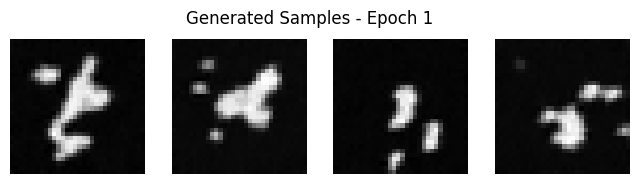

Epoch 2/20: 100%|██████████| 469/469 [00:56<00:00,  8.37it/s, loss=0.0213]


Saved best model at epoch 2 with validation loss: 0.0252
Epoch 2, Train Loss: 0.0278, Val Loss: 0.0252


Sampling: 1000it [00:08, 118.03it/s]


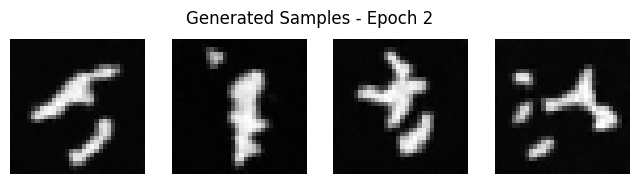

Epoch 3/20: 100%|██████████| 469/469 [00:55<00:00,  8.45it/s, loss=0.0248]


Saved best model at epoch 3 with validation loss: 0.0241
Epoch 3, Train Loss: 0.0254, Val Loss: 0.0241


Epoch 4/20: 100%|██████████| 469/469 [00:55<00:00,  8.47it/s, loss=0.031] 


Saved best model at epoch 4 with validation loss: 0.0216
Epoch 4, Train Loss: 0.0232, Val Loss: 0.0216


Sampling: 1000it [00:08, 118.85it/s]


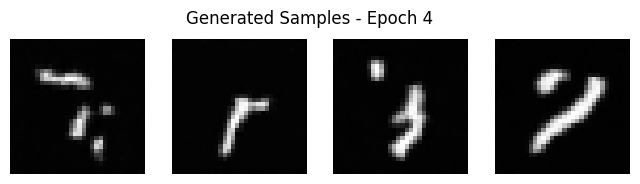

Epoch 5/20: 100%|██████████| 469/469 [00:56<00:00,  8.23it/s, loss=0.0203]


Saved best model at epoch 5 with validation loss: 0.0213
Epoch 5, Train Loss: 0.0221, Val Loss: 0.0213


Epoch 6/20: 100%|██████████| 469/469 [00:55<00:00,  8.47it/s, loss=0.0231]


Saved best model at epoch 6 with validation loss: 0.0198
Epoch 6, Train Loss: 0.0207, Val Loss: 0.0198


Sampling: 1000it [00:08, 118.56it/s]


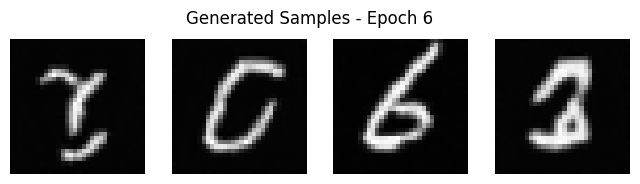

Epoch 7/20: 100%|██████████| 469/469 [00:55<00:00,  8.44it/s, loss=0.0226]


Saved best model at epoch 7 with validation loss: 0.0193
Epoch 7, Train Loss: 0.0201, Val Loss: 0.0193


Epoch 8/20: 100%|██████████| 469/469 [00:55<00:00,  8.49it/s, loss=0.0116]


Saved best model at epoch 8 with validation loss: 0.0188
Epoch 8, Train Loss: 0.0197, Val Loss: 0.0188


Sampling: 1000it [00:08, 115.53it/s]


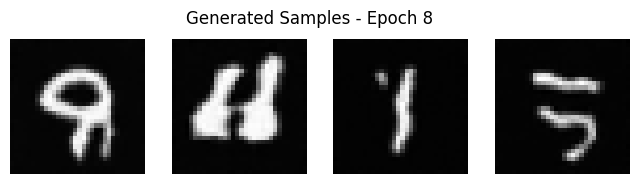

Epoch 9/20: 100%|██████████| 469/469 [00:56<00:00,  8.35it/s, loss=0.0187]


Saved best model at epoch 9 with validation loss: 0.0184
Epoch 9, Train Loss: 0.0190, Val Loss: 0.0184


Epoch 10/20: 100%|██████████| 469/469 [00:55<00:00,  8.45it/s, loss=0.0229]


Saved best model at epoch 10 with validation loss: 0.0184
Epoch 10, Train Loss: 0.0186, Val Loss: 0.0184


Sampling: 1000it [00:08, 116.09it/s]


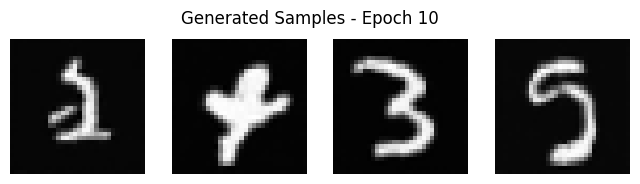

Epoch 11/20: 100%|██████████| 469/469 [00:55<00:00,  8.41it/s, loss=0.016] 


Saved best model at epoch 11 with validation loss: 0.0181
Epoch 11, Train Loss: 0.0183, Val Loss: 0.0181


Epoch 12/20: 100%|██████████| 469/469 [00:54<00:00,  8.54it/s, loss=0.0191]


Saved best model at epoch 12 with validation loss: 0.0181
Epoch 12, Train Loss: 0.0180, Val Loss: 0.0181


Sampling: 1000it [00:08, 113.80it/s]


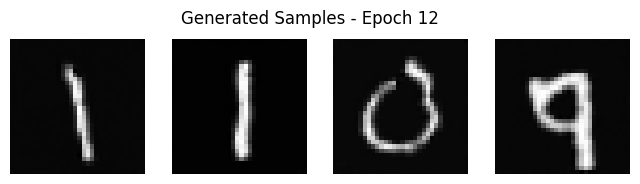

Epoch 13/20: 100%|██████████| 469/469 [00:56<00:00,  8.36it/s, loss=0.0176]


Saved best model at epoch 13 with validation loss: 0.0173
Epoch 13, Train Loss: 0.0180, Val Loss: 0.0173


Epoch 14/20: 100%|██████████| 469/469 [00:55<00:00,  8.50it/s, loss=0.017]  


Epoch 14, Train Loss: 0.0179, Val Loss: 0.0174


Sampling: 1000it [00:08, 117.45it/s]


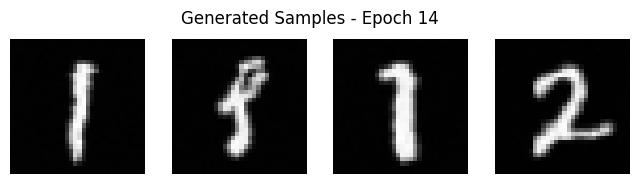

Epoch 15/20: 100%|██████████| 469/469 [00:55<00:00,  8.40it/s, loss=0.0148]


Epoch 15, Train Loss: 0.0178, Val Loss: 0.0174


Epoch 16/20: 100%|██████████| 469/469 [00:55<00:00,  8.47it/s, loss=0.0162] 


Epoch 16, Train Loss: 0.0175, Val Loss: 0.0176


Sampling: 1000it [00:08, 116.53it/s]


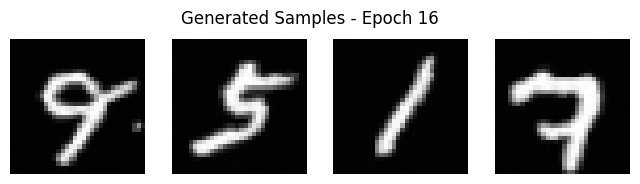

Epoch 17/20: 100%|██████████| 469/469 [00:55<00:00,  8.43it/s, loss=0.0158]


Epoch 17, Train Loss: 0.0175, Val Loss: 0.0183


Epoch 18/20: 100%|██████████| 469/469 [00:55<00:00,  8.43it/s, loss=0.0157]


Saved best model at epoch 18 with validation loss: 0.0165
Epoch 18, Train Loss: 0.0172, Val Loss: 0.0165


Sampling: 1000it [00:08, 114.92it/s]


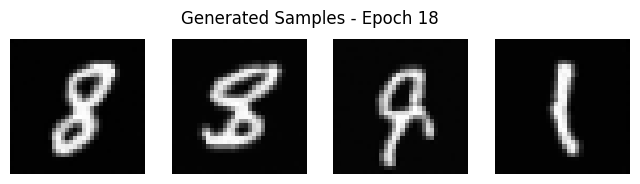

Epoch 19/20: 100%|██████████| 469/469 [00:55<00:00,  8.44it/s, loss=0.021] 


Epoch 19, Train Loss: 0.0171, Val Loss: 0.0166


Epoch 20/20: 100%|██████████| 469/469 [00:55<00:00,  8.52it/s, loss=0.0183]


Saved best model at epoch 20 with validation loss: 0.0164
Epoch 20, Train Loss: 0.0171, Val Loss: 0.0164


Sampling: 1000it [00:08, 117.37it/s]


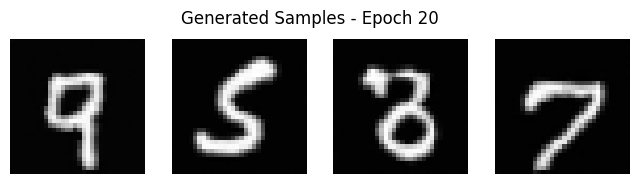

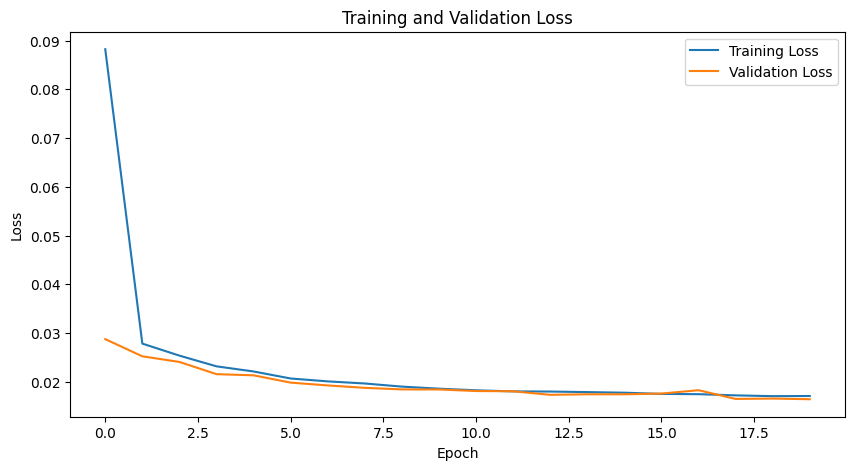

Generating final samples...


Sampling: 1000it [00:14, 70.15it/s]


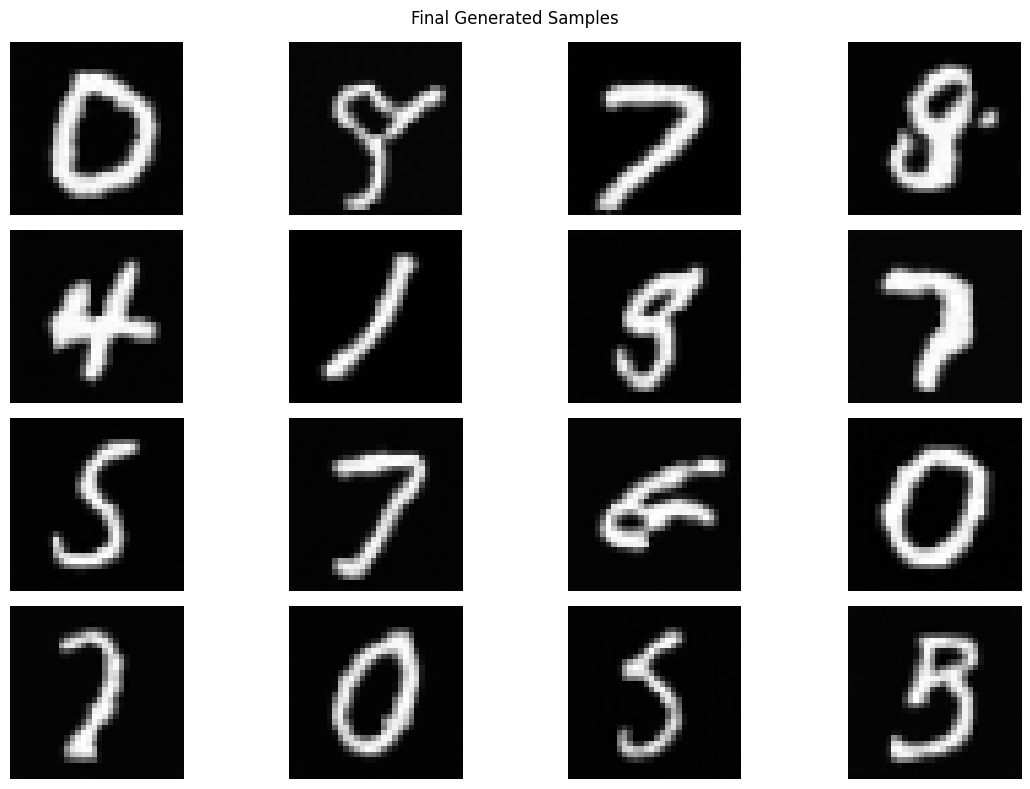

In [8]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Set to the GPU you want to use
# Set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize model and diffusion process
model = SimpleUnet(in_channels=1).to(device)
timesteps = 1000
beta_schedule = linear_beta_schedule(timesteps).to(device)
diffusion = DiffusionProcess(beta_schedule)

# Train the model
trained_model = train_diffusion_model(
    model=model,
    train_dataset=train_dataset,
    val_dataset=test_dataset,
    diffusion=diffusion,
    device=device,
    epochs=20,  # Reduced from 100 for faster training
    batch_size=128,
    eval_every_n_epochs=2,
    lr=1e-3
)

/var/folders/np/qz5mqdbj5fl9khbxwqpf9q340000gn/T/ipykernel_38113/3647024450.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(mode

Generating final samples...


Sampling: 1000it [00:07, 133.12it/s]


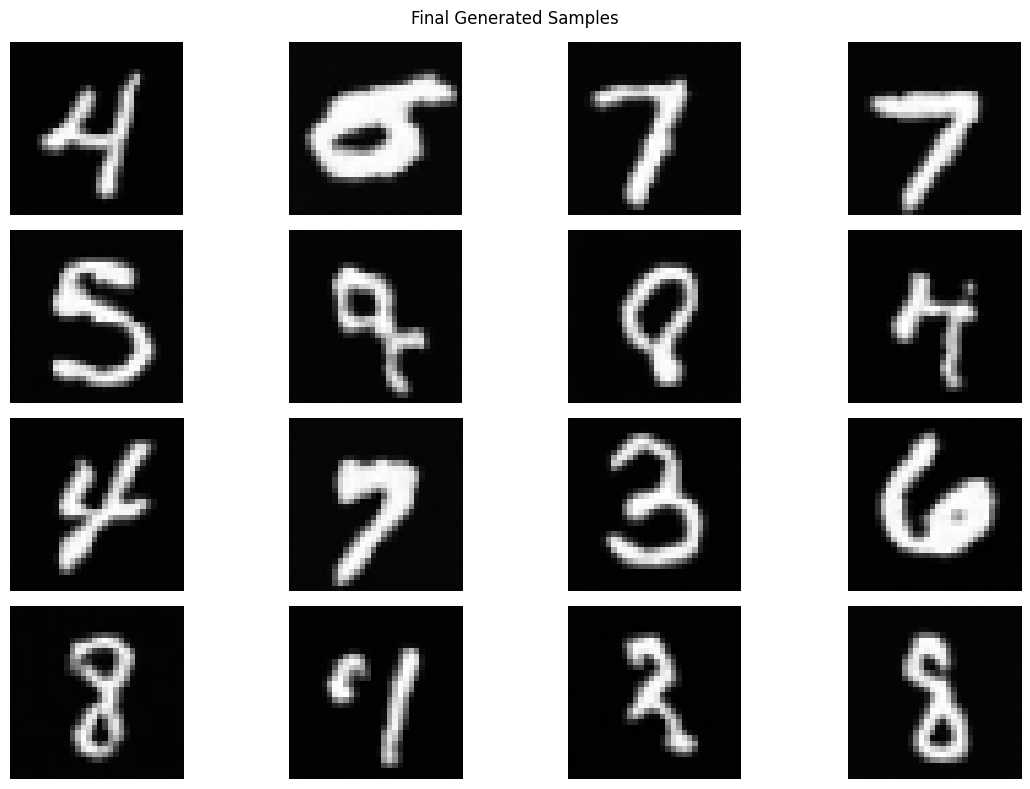

In [10]:
# Load the best model
model_path = os.path.join('models', 'diffusion_model.pth')
trained_model.load_state_dict(torch.load(model_path))
# Set the model to evaluation mode
trained_model.eval()

# Generate final samples
print("Generating final samples...")
final_samples = diffusion.sample(trained_model, n_samples=16, device=device)
plt.figure(figsize=(12, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(final_samples[i].cpu().squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Final Generated Samples")
plt.tight_layout()
plt.show()